In [27]:
import tqdm
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import optuna

import numpy as np

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [28]:
env = gym.make('Blackjack-v1', natural=True)

**Часть первая, с блекджеком и стратегиями**

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [29]:
num_episodes = 1000000
average_reward = 0

def simplest_policy(state):
    if state[0] >= 19: 
        return 0
    return 1
    
for item in tqdm.tqdm(range(num_episodes)):
    state = env.reset()
    is_done = False
    while not is_done:
        action = simplest_policy(state)
        state, reward, is_done, _ = env.step(action)
    average_reward += (reward - average_reward) / (item + 1)
    
print(f"Выигрыш от наивной стратегии: {average_reward}")

 16%|█▋        | 164908/1000000 [00:10<00:52, 15893.03it/s]


KeyboardInterrupt: 

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.¶

In [30]:
class Qlearning:
    
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        env = 'Blackjack-v1'
        self.env = gym.make('Blackjack-v1', natural=True)
        self.na = self.env.action_space.n
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, num_episodes=100000):
        for _ in range(num_episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                    (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, num_episodes=100000):
        average_reward = 0
        for i in range(num_episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            average_reward += (reward - average_reward) / (i + 1)
        return average_reward

In [31]:
%%time
QL = Qlearning()
QL.train(num_episodes=1000000)
average_reward = QL.inference(num_episodes=100000)

CPU times: user 1min 30s, sys: 1.45 s, total: 1min 32s
Wall time: 1min 31s


In [7]:
print(f"Средний выигрыш Q-learning: {average_reward}")

Средний выигрыш Q-learning: -0.10102999999999958


Monte Carlo control

In [9]:
def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, num_episodes=100000):
    average_reward = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        average_reward += (reward - average_reward) / (i + 1)
    return average_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], env.action_space.n)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [10]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
mc_avg_reward = MC_inference(Q_mc, num_episodes=100000)

In [11]:
print(mc_avg_reward)

-0.05147999999999982


3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [13]:
%%time
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'eps': trial.suggest_float('eps', 0.05, 0.5),
    }
    QL = Qlearning(alpha=params.get('alpha'), eps=params.get('eps'))
    QL.train(10000)
    return QL.inference()
    

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
best_trial = study.best_trial

print("Value: {}".format(best_trial.value))

print("  Params: ")
for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

[I 2021-10-16 08:45:25,626] Trial 0 finished with value: -0.09150000000000036 and parameters: {'alpha': 0.003277054429077573, 'eps': 0.20072363546122018}. Best is trial 0 with value: -0.09150000000000036.
[I 2021-10-16 08:45:32,192] Trial 1 finished with value: -0.10889000000000075 and parameters: {'alpha': 0.008921958684586855, 'eps': 0.32815023395661247}. Best is trial 0 with value: -0.09150000000000036.
[I 2021-10-16 08:45:38,980] Trial 2 finished with value: -0.07223999999999901 and parameters: {'alpha': 0.0012859450884289499, 'eps': 0.4420764135119344}. Best is trial 2 with value: -0.07223999999999901.
[I 2021-10-16 08:45:46,185] Trial 3 finished with value: -0.08262000000000064 and parameters: {'alpha': 0.00832913369591578, 'eps': 0.05196854866614797}. Best is trial 2 with value: -0.07223999999999901.
[I 2021-10-16 08:45:54,083] Trial 4 finished with value: -0.10548000000000064 and parameters: {'alpha': 0.005963833957486397, 'eps': 0.2920658698169006}. Best is trial 2 with value:

Number of finished trials: 100
Best trial:
Value: -0.062399999999999824
  Params: 
alpha: 0.0023373376040925022
eps: 0.4486894371719986
CPU times: user 12min 17s, sys: 19.1 s, total: 12min 36s
Wall time: 12min 40s


In [15]:
print(f"Лучший выигрыш: {best_trial.value}, alpha: {best_trial.params['alpha']}, eps: {best_trial.params['eps']}")

Лучший выигрыш: -0.062399999999999824, alpha: 0.0023373376040925022, eps: 0.4486894371719986


In [22]:
%%time
QL = Qlearning(
    alpha=best_trial.params['alpha'],
    eps=best_trial.params['eps'],
)
sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm.tqdm(range(100)):
    QL.train(1000)
    sum_of_rewards = QL.inference()
    sums_of_rewards.append(sum_of_rewards)

100%|██████████| 100/100 [10:50<00:00,  6.50s/it]


CPU times: user 10min 44s, sys: 21.3 s, total: 11min 6s
Wall time: 10min 55s


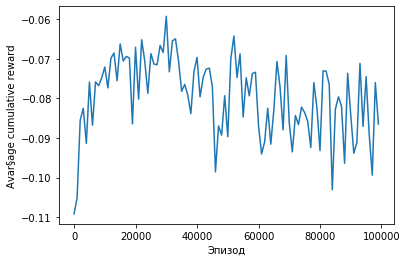

In [23]:
plt.plot(range(0, 100000, 1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avar§age cumulative reward')
plt.show()

In [27]:
%%time
import optuna

def objective(trial):
    params = {
        'gamma': trial.suggest_float('gamma', 0, 100),
    }
    Q_mc, evaluations = monte_carlo(gamma=params['gamma'], episodes=5000, evaluate=False)
    return MC_inference(Q_mc, num_episodes=100000)
    

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
best_trial = study.best_trial

print("Value: {}".format(best_trial.value))

print("  Params: ")
for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

Number of finished trials: 100
Best trial:
Value: -0.05652999999999999
  Params: 
gamma: 0.033964537205777356
CPU times: user 9min 51s, sys: 18.6 s, total: 10min 9s
Wall time: 9min 54s


**Часть вторая, удвоенная**

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [13]:
class Doubled_Blackjack_V0:
    
    def __init__(self):
        self.base_env = gym.make('Blackjack-v1', natural=True)
        self.action_space = list(range(3))
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:
            state, reward, is_done, _ = self.base_env.step(1)
            
            if is_done:
                return state, 2 * reward, is_done, _
            else:
                state, reward, is_done, _ = self.base_env.step(0)
                return state, 2 * reward, is_done, _
            
        else:
            return self.base_env.step(action)

In [14]:
class Qlearning_Doubled_Blackjack:
    
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.env = Doubled_Blackjack_V0()
        self.na = 3
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, num_episodes=100_000):
        for n in range(num_episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, num_episodes=100_000):
        average_reward = 0
        for i in range(num_episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            average_reward += (reward - average_reward) / (i + 1)
        return average_reward

In [15]:
%%time
QL_Doubled = Qlearning_Doubled_Blackjack()
QL_Doubled.train(100_000_0)
QL_Doubled.inference()

CPU times: user 1min 23s, sys: 1.87 s, total: 1min 25s
Wall time: 1min 23s


-0.06698000000000097

In [32]:
env = Doubled_Blackjack_V0()

def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, num_episodes=100000):
    average_reward = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        average_reward += (reward - average_reward) / (i + 1)
    return average_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(3))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], 3)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [17]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
MC_inference(Q_mc, num_episodes=100000)

-0.05728000000000025

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [18]:
%%time
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'eps': trial.suggest_float('eps', 0.05, 0.5),
    }
    QL = Qlearning_Doubled_Blackjack(alpha=params.get('alpha'), eps=params.get('eps'))
    QL.train(100_000)
    return QL.inference()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
best_trial = study.best_trial

print("Value: {}".format(best_trial.value))
print("Params: ")
for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

Number of finished trials: 100
Best trial:
Value: -0.06209999999999983
Params: 
alpha: 0.0004889955080298381
eps: 0.4971099624585629
CPU times: user 24min 38s, sys: 22.5 s, total: 25min
Wall time: 25min 4s


In [24]:
%%time
QL_Doubled = Qlearning_Doubled_Blackjack(
    alpha=best_trial.params['alpha'],
    eps=best_trial.params['eps']
)
sums_of_rewards = []
best_sum_of_rewards = [QL_Doubled.inference()]
for i in tqdm.tqdm(range(50)):
    QL_Doubled.train(1000)
    sum_of_rewards = QL_Doubled.inference()
    sums_of_rewards.append(sum_of_rewards)

100%|██████████| 50/50 [05:44<00:00,  6.90s/it]


CPU times: user 5min 43s, sys: 8.33 s, total: 5min 51s
Wall time: 5min 50s


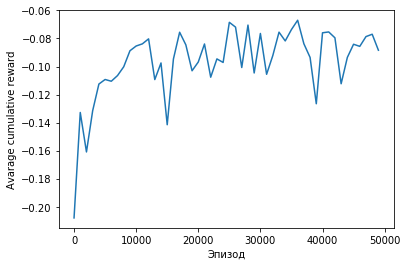

In [25]:
plt.plot(range(0, 50_000, 1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

100%|██████████| 100/100 [17:31<00:00, 10.51s/it]


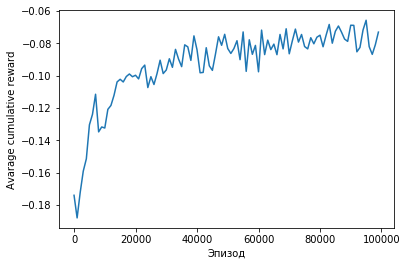

CPU times: user 17min 28s, sys: 26.4 s, total: 17min 54s
Wall time: 17min 37s


In [34]:
%%time

sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm.tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=1, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)
    
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

**Часть третья, в главной роли — Дастин Хоффман**

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.¶

In [44]:
from gym.envs.toy_text.blackjack import cmp, is_bust, is_natural, score, sum_hand
from gym import spaces
from gym.envs.toy_text.blackjack import BlackjackEnv


class Doubled_Blackjack_V0(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        self.base_env = gym.make('Blackjack-v1', natural=True)
        self.action_space = list(range(3))
        super(BlackjackEnv, self).__init__(*args, **kwargs)
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:
            state, reward, is_done, _ = self.base_env.step(1)
            if done:
                return state, 2*reward, is_done, _
            else:
                state, reward, is_done, _ = self.base_env.step(0)
                return state, 2*reward, is_done, _
        else:
            return self.base_env.step(action)

class HoffmanBlackjackEnv(Doubled_Blackjack_V0):
    def __init__(self, *args, **kwargs):
        self.base_env = gym.make('Blackjack-v1', natural=True)
        self.na = 3
        self.natural = True
        self.action_space = spaces.Discrete(3)
        self.sum_card = 0
        self.initial_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.deck = self.initial_deck.copy()
        self.card_cost = {
            1: -1,
            2: +0.5,
            3: +1,
            4: +1,
            5: +1.5,
            6: +1,
            7: +0.5,
            8: +0,
            9: -0.5,
            10: -1,
        }
        super(HoffmanBlackjackEnv, self).__init__(*args, **kwargs)
        
    def reset(self):
        if len(self.deck) <= 15:
            self.sum_card = 0
            self.deck = self.initial_deck.copy()
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        self.sum_card += self.card_cost[card]
        return int(card)
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
        
    def _get_obs(self):
        return (*super(Doubled_Blackjack_V0, self)._get_obs(), self.sum_card)
    
    def step(self, action):
        if action: 
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
                
                
            reward = cmp(score(self.player), score(self.dealer))
            
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        return self._get_obs(), reward, done, {}

In [45]:
class Qlearning_hoffman():
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.env = HoffmanBlackjackEnv()
        self.na = 3
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, num_episodes=100000):
        for n in range(num_episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, num_episodes=100000):
        average_reward = 0
        for i in range(num_episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            average_reward += (reward - average_reward) / (i + 1)
        return average_reward

In [46]:
%%time
QL_Hoffman = Qlearning_hoffman()
QL_Hoffman.train(100_000_0)
QL_Hoffman.inference()

CPU times: user 1min 54s, sys: 1.84 s, total: 1min 56s
Wall time: 1min 57s


-0.062485000000000214

In [47]:
env = HoffmanBlackjackEnv()

def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, num_episodes=100000):
    average_reward = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        average_reward += (reward - average_reward) / (i + 1)
    #print(f"Средний выигрыш после {num_episodes} эпизодов Monte Carlo control: {average_reward}")
    return average_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(3))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], 3)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [48]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
MC_inference(Q_mc, num_episodes=100000)

-0.03640499999999975

In [49]:
%%time
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'eps': trial.suggest_float('eps', 0.05, 0.5),
    }
    QL = Qlearning_hoffman(alpha=params.get('alpha'), eps=params.get('eps'))
    QL.train(100_000)
    return QL.inference()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
best_trial = study.best_trial

print("Value: {}".format(best_trial.value))
print("Params: ")
for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

Number of finished trials: 100
Best trial:
Value: -0.06084500000000045
Params: 
alpha: 0.001256685921485561
eps: 0.4920035053913415
CPU times: user 30min 15s, sys: 31.3 s, total: 30min 46s
Wall time: 30min 45s


In [51]:
%%time
QL_Hoffman = Qlearning_hoffman(alpha=best_trial.params['alpha'], eps=best_trial.params['eps'])
sums_of_rewards = []
best_sum_of_rewards = [QL_Hoffman.inference()]
for i in tqdm.tqdm(range(100)):
    QL_Hoffman.train(1000)
    sum_of_rewards = QL_Hoffman.inference()
    sums_of_rewards.append(sum_of_rewards)

100%|██████████| 100/100 [13:43<00:00,  8.24s/it]


CPU times: user 13min 37s, sys: 18.9 s, total: 13min 56s
Wall time: 13min 51s


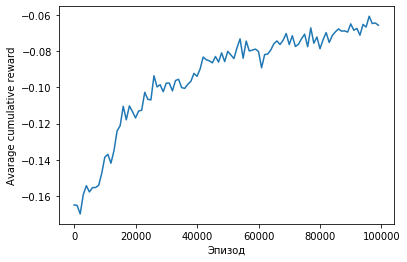

In [52]:
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

100%|██████████| 100/100 [22:15<00:00, 13.35s/it]


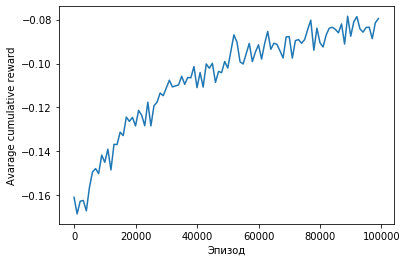

CPU times: user 22min 9s, sys: 29.5 s, total: 22min 38s
Wall time: 22min 21s


In [54]:
%%time

sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm.tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=1, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)
    
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()